In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from datetime import date, timedelta
import datetime
import gc
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
te_start='2019-06-27'
te_end = '2019-08-07'

In [ ]:
forecast_period = (pd.to_datetime(te_end)-pd.to_datetime(te_start)).days+1
forecast_period

42

In [ ]:
holdout = a[a['WDATE']>=te_start]

In [ ]:
rev_rank = holdout.groupby('ITEM').apply(sum)['AMT_ACT'].reset_index()
rev_rank = rev_rank.sort_values('AMT_ACT',ascending=False).reset_index(drop=True)
rev_rank['rank']=pd.DataFrame(np.array(["{0:03}".format(i) for i in range(1,len(rev_rank)+1)]).reshape(-1,1))
rev_rank['pct']=round(rev_rank['AMT_ACT']/sum(rev_rank['AMT_ACT'])*100,2)
rev_rank = rev_rank[rev_rank['pct']>=1]
rev_rank['pct'] = rev_rank['pct'].astype('str')
rev_rank['list']=rev_rank['rank']+'_'+rev_rank['ITEM']+'('+rev_rank['pct']+'%)'
rev_rank = rev_rank[['ITEM','list']]

In [ ]:
len(rev_rank.list.unique())

17

In [ ]:
a=pd.merge(a,rev_rank,how='inner',on='ITEM')
a.drop('ITEM',axis=1,inplace=True)
a.columns=['WDATE','value','ITEM']

In [ ]:
a = a.groupby(['WDATE','ITEM']).apply(sum)['value']
a = a.reset_index()

In [ ]:
a.WDATE=pd.to_datetime(a.WDATE)

In [ ]:
a=a.sort_values(['WDATE','ITEM'])

In [ ]:
# np.sort(a.ITEM.unique())

In [ ]:
# for item in np.sort(a.ITEM.unique()):
#   plt.figure(figsize=(18,5))
#   plt.plot(a[a.ITEM==item]['WDATE'],a[a.ITEM==item]['value'])
#   plt.title(item)

In [ ]:
# a.value=np.log1p(a.value).fillna(0)

In [ ]:
b = a.pivot('WDATE','ITEM','value')
c = (b-b.median())/b.std()
df_train = c.T.fillna(0)

In [ ]:
# df_train = a

In [ ]:
# len(df_train.WDATE.unique())

In [ ]:
# df_train = df_train.set_index(["ITEM", "WDATE"])[["value"]].unstack(level=-1).fillna(0)
# df_train

In [ ]:
# df_train.columns = df_train.columns.get_level_values(1)
# df_train

In [ ]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), 
                            periods=periods, freq=freq)]

In [ ]:
def prepare_dataset(df,
#                     promo_df,
                    t2017, is_train=True, name_prefix=None):
    X = pd.DataFrame()

    for i in [3, 5, 7, 14, 28, 56]:
        tmp = get_timespan(df, t2017, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['diff_%s_median' % i] = tmp.diff(axis=1).median(axis=1).values
        X['diff_%s_min' % i] = tmp.diff(axis=1).min(axis=1).values
        X['diff_%s_max' % i] = tmp.diff(axis=1).max(axis=1).values
        X['diff_%s_std' % i] = tmp.diff(axis=1).std(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
#         X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
#        X['std_%s' % i] = tmp.std(axis=1).values

    for i in [3, 5, 7, 14, 28, 56]:
        tmp = get_timespan(df, t2017 + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['diff_%s_median_2' % i] = tmp.diff(axis=1).median(axis=1).values
        X['diff_%s_min_2' % i] = tmp.diff(axis=1).min(axis=1).values
        X['diff_%s_max_2' % i] = tmp.diff(axis=1).max(axis=1).values
        X['diff_%s_std_2' % i] = tmp.diff(axis=1).std(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
#        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
#        X['std_%s_2' % i] = tmp.std(axis=1).values

#    for i in [28, 56]:
#        tmp = get_timespan(df, t2017, i, i)
#        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
#        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
#        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    for i in range(1, 8):
        X['day_%s_lag' % i] = get_timespan(df, t2017, i, 1).values.ravel()
        X['diff_%s_lag' % i] = get_timespan(df,t2017,i+1,i+1).diff(axis=1,periods=i).iloc[:,-1].values
        
    for i in range(7):
        X['mean_4_dow{}'.format(i)] = get_timespan(df, t2017, 4*7-i, 4, freq='7D').mean(axis=1).values
#        X['mean_8_dow{}'.format(i)] = get_timespan(df, t2017, 8*7-i, 8, freq='7D').mean(axis=1).values
#        X['mean_12_dow{}'.format(i)] = get_timespan(df, t2017, 12*7-i, 12, freq='7D').mean(axis=1).values
#        X['mean_16_dow{}'.format(i)] = get_timespan(df, t2017, 16*7-i, 16, freq='7D').mean(axis=1).values
#        X['mean_20_dow{}'.format(i)] = get_timespan(df, t2017, 20*7-i, 16, freq='7D').mean(axis=1).values

    X = pd.DataFrame(X)

    if is_train:
        y = df[
            pd.date_range(t2017, periods=1)
        ].values
        return X, y
      
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    return X

In [ ]:
params = {
    'boost_from_average': True,
    'colsample_bytree':0.3,
    'Decay': 'linear',
    'early_stopping_rounds':200,
    'fair_c':1,
    'huber_delta':1.0,
    'learning_rate': 0.43,
    'link_transform': False,
    'max_bin': 255,
    'max_delta_step':0.7,
    'max_depth': None,
    'min_child_samples': 10,
    'min_child_weight':5,
    'min_split_gain': 0.0,
    'n_estimators': 5000,
    'num_leaves': 64,
    'objective': 'regression_l2',
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample':0.0285714285714,
    'subsample_for_bin': 50000,
    'subsample_freq': 1,
    'tweedie_p':1.5,
    
#     'min_data_in_leaf': 200,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'metric': 'l2',
#     'num_threads': 8
}

In [ ]:
MAX_ROUNDS = 5000
val_pred = []
feat_imp = []
for i in range(forecast_period):
  print("=" * 50)
  print("Step %d" % (i+1))
  print("=" * 50)
  
  t2017 = date(2019, 6, 27) - timedelta(days=364-i)
  num_days = int(364)
  X_l, y_l = [], []
  
  for n in range(num_days):
    delta = timedelta(days=n)
    X_tmp, y_tmp = prepare_dataset(df_train, t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

  gc.collect()
    
  X_train = pd.concat(X_l, axis=0)
  y_train = np.concatenate(y_l, axis=0)
  X_val, y_val = prepare_dataset(df_train, date(2019, 6, 27)+timedelta(days=i))
                                     
  dtrain = lgb.Dataset(X_train, label=y_train.reshape(-1,))
                                 
  dval = lgb.Dataset(X_val, label=y_val.reshape(-1,), reference=dtrain)
                                   
  bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,valid_sets=[dtrain, dval], verbose_eval=50)
                                   
  print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
  feat_imp.append(bst.feature_importance("gain"))                      
  val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    
  if i < (forecast_period-1):
    df_train[df_train.columns[-(42-i)]]=bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)

Step 1


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[50]	training's l2: 1.36577	valid_1's l2: 1.6853
[100]	training's l2: 2.34532	valid_1's l2: 2.61272
[150]	training's l2: 3.11852	valid_1's l2: 5.91333
[200]	training's l2: 3.68887	valid_1's l2: 3.20721
Early stopping, best iteration is:
[2]	training's l2: 0.738172	valid_1's l2: 0.302225
mean_28_decay: 48.25
mean_3: 22.57
mean_4_dow6: 10.85
diff_56_max_2: 10.84
diff_28_min_2: 9.98
max_3_2: 5.96
median_5: 5.80
day_4_lag: 3.87
diff_3_std: 1.91
diff_14_median_2: 1.67
diff_5_mean_2: 1.41
max_3: 1.06
diff_14_max_2: 0.63
mean_4_dow0: 0.42
mean_14_decay_2: 0.35
diff_14_max: 0.34
diff_5_lag: 0.00
diff_3_min: 0.00
diff_3_mean: 0.00
diff_3_median: 0.00
diff_3_max: 0.00
mean_3_decay: 0.00
median_3: 0.00
diff_5_mean: 0.00
diff_5_median: 0.00
diff_5_min: 0.00
diff_5_max: 0.00
diff_5_std: 0.00
mean_5_decay: 0.00
mean_5: 0.00
max_5: 0.00
diff_7_mean: 0.00
diff_7_median: 0.00
diff_7_min: 0.00
diff_7_max: 0.00
diff_7_std: 0.00
mean_7_decay: 

In [ ]:
feat_eval = np.array(feat_imp).transpose()
df_feat_eval = pd.DataFrame(feat_eval, index = X_train.columns)
df_feat = df_feat_eval.copy()
df_feat['evg']=df_feat_eval.mean(axis=1)
df_feat['max']=df_feat_eval.max(axis=1)
df_feat['#0'] = (df_feat_eval==0).sum(axis=1).values
# df_feat['!0'] = (df_feat_eval>0).sum(axis=1).values

df_feat[['evg','max','#0']].sort_values(['evg','#0'])
#df_feat.loc[X_train.columns.str.contains(pat='')][['evg','#0']]


,evg,max,#0
diff_7_min,0.000000,0.000000,42
median_7,0.000000,0.000000,42
diff_56_min,0.000000,0.000000,42
diff_56_max,0.000000,0.000000,42
mean_56_decay,0.000000,0.000000,42
diff_3_mean_2,0.000000,0.000000,42
diff_5_median_2,0.000000,0.000000,42
diff_5_std_2,0.000000,0.000000,42
diff_7_mean_2,0.000000,0.000000,42
diff_14_min_2,0.000000,0.000000,42


In [ ]:
y_val = np.array(val_pred).transpose()
df_preds = pd.DataFrame(
    y_val, index=df_train.index,
    columns=pd.date_range(te_start, periods=forecast_period)
).stack().to_frame("value")
df_preds.index.set_names(["ITEM", "WDATE"], inplace=True)
# df_preds["value"] = np.expm1(df_preds["value"])
# df_preds.reset_index().to_csv('lgb_0826.csv', index=False)

In [ ]:
df_preds=df_preds.reset_index()

In [ ]:
df_preds = (df_preds.pivot('WDATE','ITEM','value')*b.std()+b.median())

In [ ]:
# a.value = np.expm1(a.value)
a = a[a.WDATE>=te_start]

In [ ]:
polo=a.pivot(index='ITEM',columns='WDATE',values='value').fillna(0)

In [ ]:
croco = pd.DataFrame(columns=polo.columns[34:], index=df_preds.columns)

In [ ]:
rmse=[]
for item in df_preds.columns:
#   rmse.append(mean_squared_error(a[a.ITEM==item]['value'],df_preds[df_preds.ITEM==item]['value'])**0.5)
  rmse.append(mean_squared_error(polo.loc[item],df_preds[item])**0.5)


In [ ]:
for item in df_preds.columns:
  residual = (np.array(df_preds[item])-np.array(polo.loc[item])).tolist()
#   residual = residual.to_list()
  cat=[]
  for i in np.arange(35, len(residual)+1):
    cat.append(sum(residual[i-35:i]))
  croco.loc[item] = cat

In [ ]:

croco['avg_35sum'] = croco.sum(axis=1)/len(croco.columns)
croco['max_35']=croco.max(axis=1)
croco['min_35']=croco.min(axis=1)
# croco['avg_35rev'] = a.groupby('ITEM').apply(sum)['value']*35/forecast_period
croco['avg_35rev'] = polo.sum(axis=1)*35/forecast_period

croco['avg_rate'] = croco['avg_35sum']/croco['avg_35rev']
croco['max_rate'] = croco['max_35']/croco['avg_35rev']
croco['min_rate'] = croco['min_35']/croco['avg_35rev']
croco['RMSE']=rmse

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


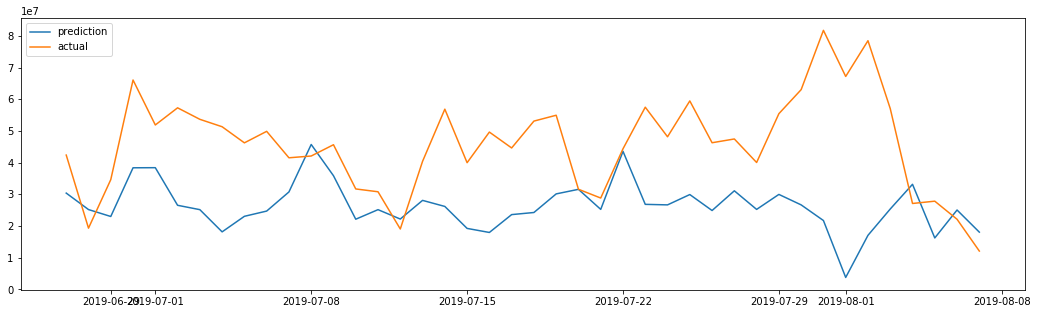

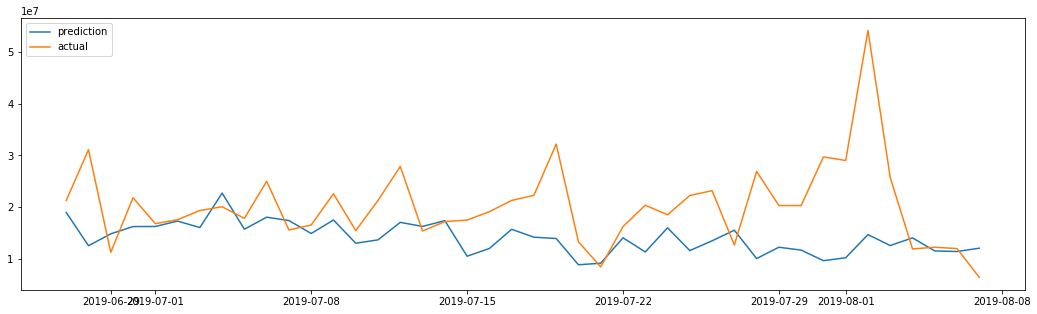

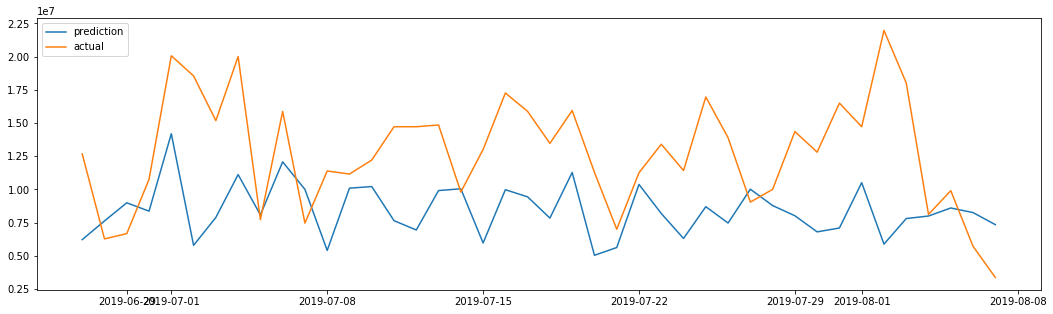

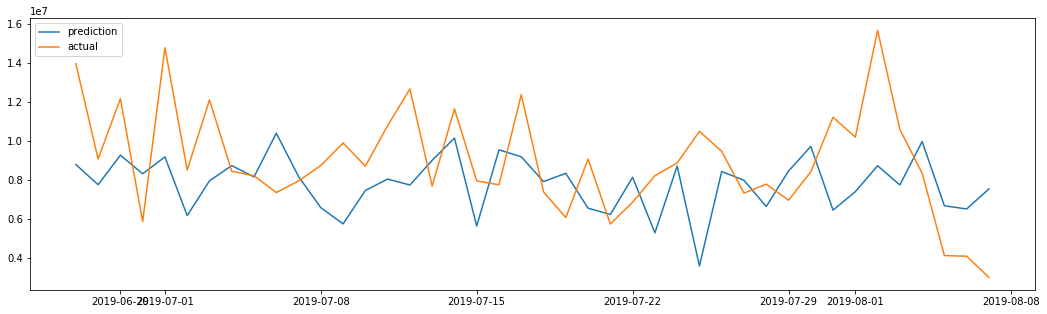

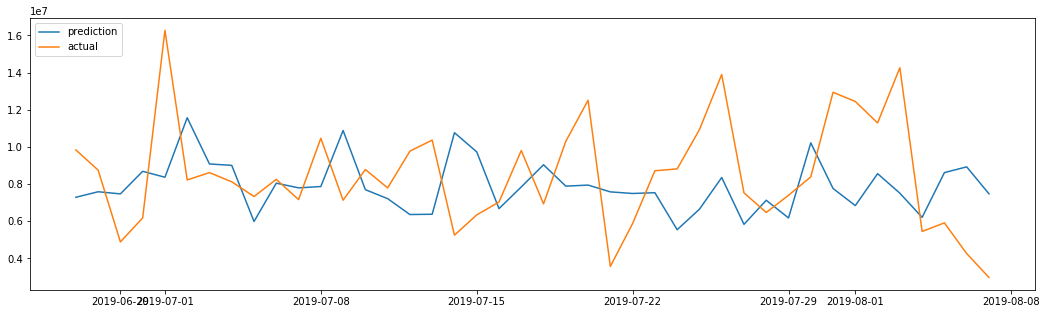

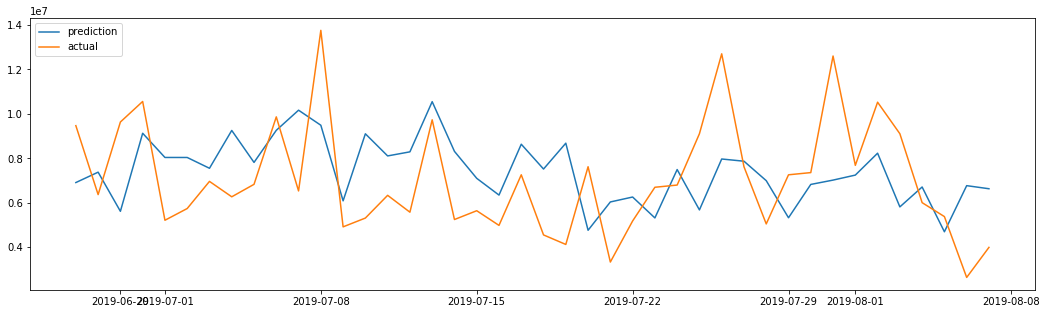

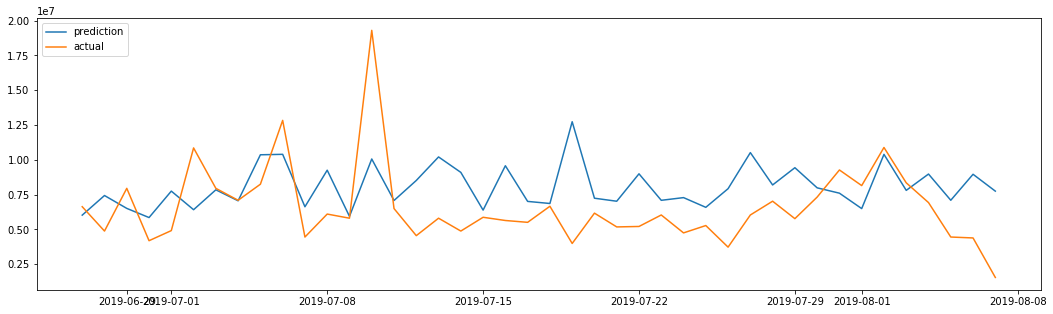

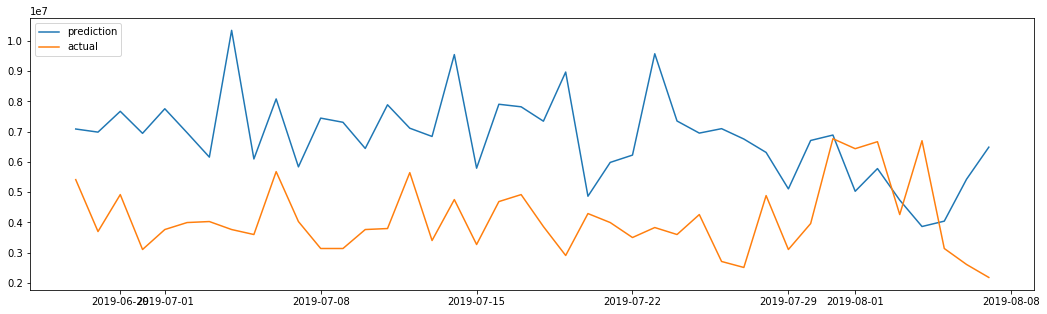

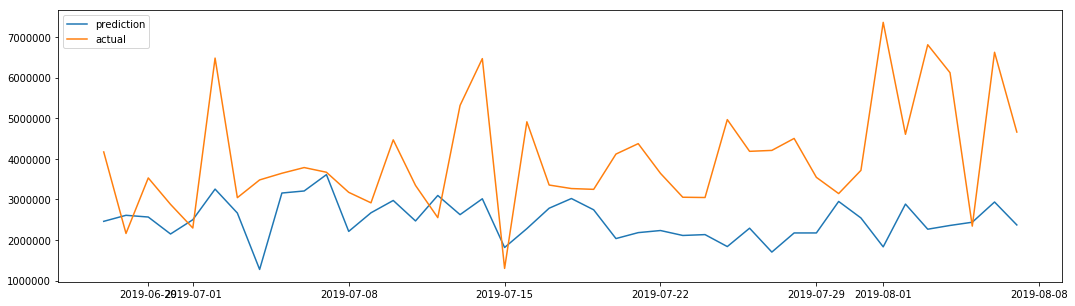

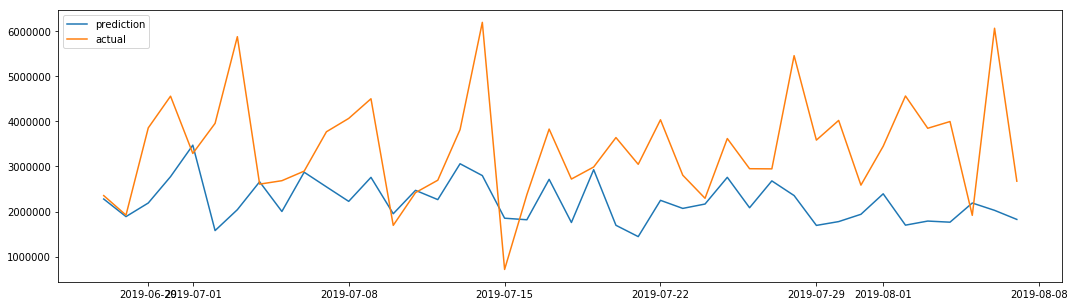

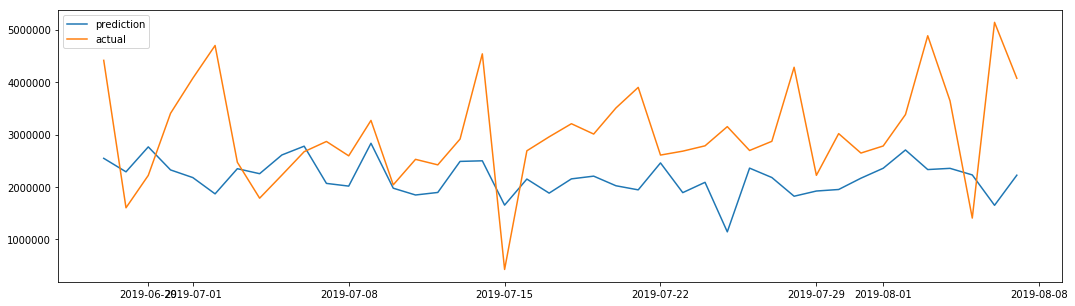

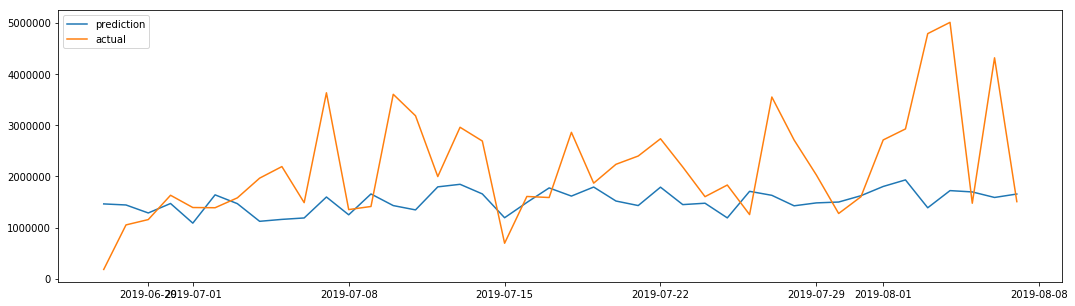

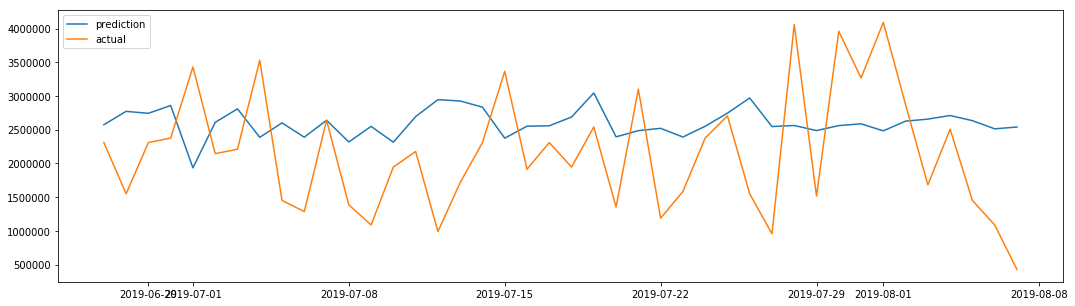

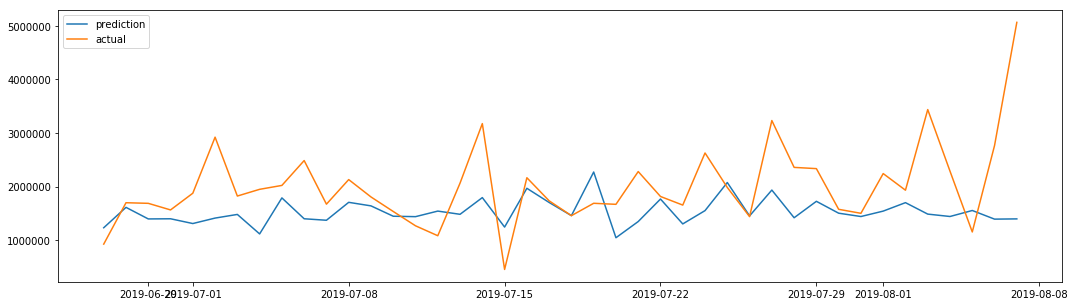

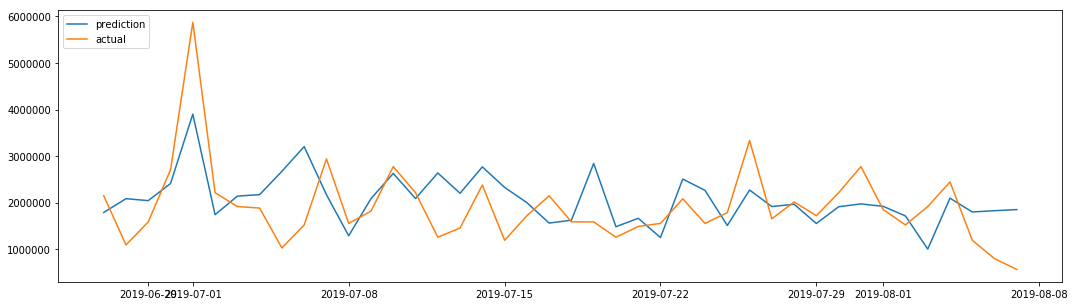

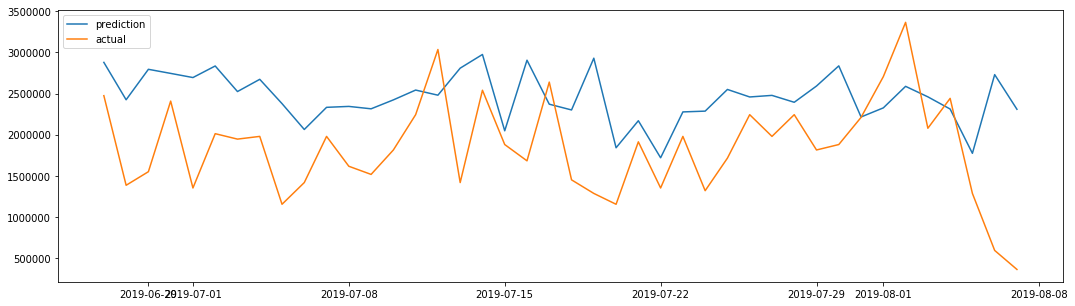

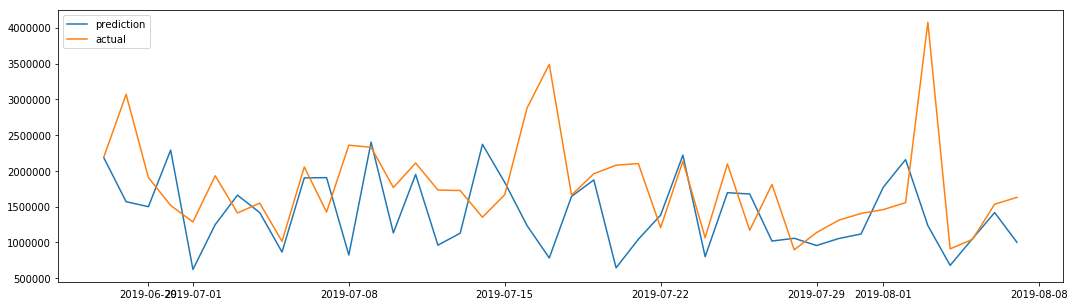

In [ ]:
for item in df_preds.columns:
  plt.figure(figsize=(18,5))
  plt.plot(polo.columns,df_preds[item], label='prediction')
#   plt.plot(a[a.ITEM==item]['WDATE'],a[a.ITEM==item]['value'], label='actual')
  plt.plot(polo.columns,polo.loc[item], label='actual')
  plt.legend(loc='upper left')
#   plt.xticks(a[a.ITEM==item]['WDATE'].values[np.arange(0,forecast_period,7)].tolist(),rotation=60)
  